In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

torch.__version__

'2.3.1+cu121'

In [2]:
!nvidia-smi

Thu Jul 25 04:27:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Generating data



In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12641363.38it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205397.09it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3739028.96it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20486031.30it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
image, target = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [6]:
classnames = train_data.classes
classnames

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_idx = train_data.class_to_idx
class_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [9]:
import matplotlib.pyplot as plt

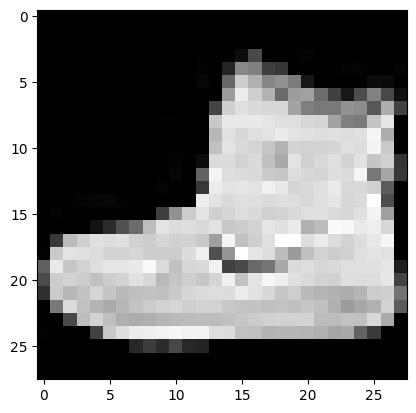

In [10]:
plt.imshow(image.squeeze(),cmap="gray")

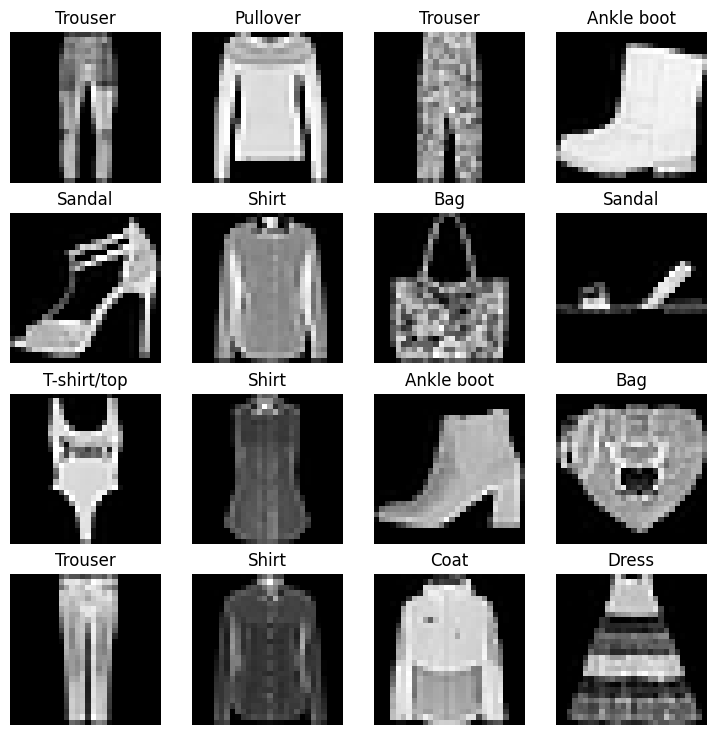

In [11]:
# torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
row, col = 4,4
for i in range(1,row*col+1):
  im_index = torch.randint(0,len(train_data),size=[1]).item()
  im, la = train_data[im_index]
  fig.add_subplot(row, col, i)
  plt.imshow(im.squeeze(), cmap="gray")
  plt.title(classnames[la])
  plt.axis(False);

### Loading data using DataLoader

In [12]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle=False)
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [13]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [14]:
flatten = nn.Flatten()
flatten(train_features_batch[1]).shape

torch.Size([1, 784])

### Building baseline model (model_0)

In [15]:
class FashionMNISTModel0(nn.Module):
  def __init__(self, input_size, output_size, hidden_units=10):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_size, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_size)
    )

  def forward(self, x):
    return self.layer_stack(x)

model0 = FashionMNISTModel0(input_size=784,
                      output_size=len(train_data.classes)).to("cpu")
model0

FashionMNISTModel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [16]:
model0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0196,  0.0081,  0.0268,  ..., -0.0066, -0.0007, -0.0109],
                      [ 0.0165,  0.0181, -0.0228,  ...,  0.0185, -0.0040,  0.0166],
                      [ 0.0114,  0.0256, -0.0185,  ...,  0.0219, -0.0297, -0.0165],
                      ...,
                      [ 0.0168,  0.0300,  0.0136,  ..., -0.0249, -0.0300,  0.0315],
                      [ 0.0037,  0.0085, -0.0296,  ..., -0.0250,  0.0004,  0.0260],
                      [-0.0091,  0.0087,  0.0215,  ...,  0.0209, -0.0341, -0.0163]])),
             ('layer_stack.1.bias',
              tensor([-0.0197,  0.0300, -0.0301,  0.0052, -0.0195,  0.0225,  0.0330, -0.0208,
                      -0.0018,  0.0305])),
             ('layer_stack.2.weight',
              tensor([[ 0.1830,  0.2004,  0.0446,  0.2357,  0.0086,  0.1160,  0.0059,  0.0493,
                       -0.1736,  0.0308],
                      [ 0.1900, -0.0269,  0.2724, -0.1900, -0.0505, -0.1799, -0.

In [17]:
# Setting loss function, optimizer and evaluation metrics
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.01)

def accuracy_fn(y_true, y_pred):
  currect = torch.eq(y_true, y_pred).sum().item()
  accuracy = (currect / len(y_pred)) * 100
  return accuracy
def calaculate_time(start_time,
                    end_time,
                    device="cpu"):
  total_time = end_time - start_time
  print(f"{total_time:.2f}s on {device}")
  return total_time

### training and testing loop

In [18]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 3
train_start_cpu = timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}")
  train_loss = 0
  for batch, (X,y) in enumerate(train_dataloader):
    # Training mode
    model0.train()

    # Forward pass
    logits = model0(X)
    y_pred = logits.argmax(dim=1)

    # calculate loss
    loss = loss_fn(logits, y)
    train_loss += loss

    # optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # updating  parameters
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)}")

  train_loss /= len(train_dataloader)

  # Testing
  test_loss, test_acc = 0, 0
  model0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:

      # forward pass
      test_logits = model0(X)
      test_pred = test_logits.argmax(dim=1)

      # Loss and accuracy
      test_loss += loss_fn(test_logits, y)
      test_acc += accuracy_fn(y_true=y,
                         y_pred=test_pred)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, test_accuracy: {test_acc:.3f}%")
train_end_cpu = timer()
training_time_cpu = calaculate_time(train_start_cpu, train_end_cpu, device= str(next(model0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 0.9081, test_loss: 0.6506, test_accuracy: 77.945%
Epoch 1
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 0.5720, test_loss: 0.5512, test_accuracy: 80.751%
Epoch 2
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 0.5070, test_loss: 0.5158, test_accuracy: 81.969%
30.55s on cpu


In [19]:
def evaluate_model(model:torch.nn.Module,
                   data_loader:torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   accuracy_fn):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      test_logits = model(X)
      test_loss += loss_fn(test_logits, y)
      test_acc += accuracy_fn(y, test_logits.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  return {"model": model.__class__.__name__,
          "test_loss": test_loss,
          "test_accuracy": test_acc}

In [20]:
model0_result = evaluate_model(model=model0,
                              data_loader=test_dataloader,
                              loss_fn= loss_fn,
                              accuracy_fn=accuracy_fn)
model0_result

  0%|          | 0/313 [00:00<?, ?it/s]

{'model': 'FashionMNISTModel0',
 'test_loss': tensor(0.5158),
 'test_accuracy': 81.96884984025559}

In [21]:
from pathlib import Path

MODEL_DIR = Path("model")
MODEL_DIR.mkdir(parents=True,
                exist_ok=True)
MODEL_NAME = "FashionMNISTClassificationV0.pth"
MODEL_PATH = MODEL_DIR / MODEL_NAME
torch.save(obj = model0.state_dict(),f=MODEL_PATH)

### Model1: Improving model with non-linearity

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_size, output_size, hidden_units=10):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_size, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_size),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

model1 = FashionMNISTModelV1(input_size=784,
                             output_size=len(train_data.classes),
                             ).to(device)

In [52]:
model1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

### Setting up loss function, optimizer, evaluation metrics(accuracy)

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.01)

#### functionising training and evaluating/testing process

In [63]:
def train_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(data_loader):
    model.train()
    X, y = X.to(device), y.to(device)
    # forward pass
    train_logits = model(X)
    train_pred = train_logits.argmax(dim=1)

    # calculating loss
    loss = loss_fn(train_logits, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=train_pred)

    # clearing gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # updating gradients
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)}")

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  return train_loss, train_acc

In [64]:
def test_model(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      # Forward pass
      test_logits = model(X)

      # Calculating loss
      test_loss += loss_fn(test_logits, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_logits.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
  return test_loss, test_acc

In [65]:
# Training improved model

epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"epoch: {epoch}---------------")
  train_loss, train_acc = train_model(model=model1,
                                      data_loader = train_dataloader,
                                      loss_fn = loss_fn,
                                      optimizer = optimizer,
                                      accuracy_fn=accuracy_fn)
  test_loss, test_acc = test_model(model=model1,
                                   data_loader=test_dataloader,
                                   loss_fn=loss_fn,
                                   accuracy_fn=accuracy_fn)
  print(f"train_loss: {train_loss:.4f}, train_acc:{train_acc:.2f}%, test_loss: {test_loss:.4f}, test_acc: {test_acc:.2f}%")

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0---------------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 1.1174, train_acc:64.59%, test_loss: 1.0339, test_acc: 65.62%
epoch: 1---------------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 0.9875, train_acc:67.01%, test_loss: 0.9801, test_acc: 66.99%
epoch: 2---------------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 0.9474, train_acc:67.64%, test_loss: 0.9569, test_acc: 67.21%


Looks like our model is weaker than the without non-linearity model